# brain imaging data manipulate

## wirte to nii, read nii, get mask data,correlation,plotting brain
## author: Donghui Song, donghuipsy@gmail.com

In [3]:
import numpy as np
import pandas as pd
import nibabel as nb
from nilearn import input_data
from nilearn import plotting as nlp
from nilearn.image import resample_to_img
from nilearn.input_data import NiftiMasker

%matplotlib inline


In [4]:
# prepare files

predict_datafile=r"/home/donghui/Public/dh_test/prediction_1s.npy" 

real_datafile=r"/home/donghui/Public/dh_test/MOVIE4_MNI.npy"

refer_imagefile=r"/home/donghui/Public/dh_test/100610_rfMRI_REST1_7T_PA_hp2000_clean.nii.gz"


In [6]:
# read data

predict_data=np.load(predict_datafile)[:,:,:,:,0]

real_data=np.load(real_datafile)

short_real_data=real_data[:,:,:,0:699]

refer_image=nb.load(refer_imagefile)

#refer_imagedata=refer_image.get_fdata()


In [8]:
all_predict_data=np.pad(predict_data,((0,0),(2,0),(4,5),(0,2)),'constant') #plus 0 to match raw data shape for write nfti file

re_all_predict_data=all_predict_data.transpose((1,2,3,0))# reorder matrix,let 4th dimension is time

In [9]:
# write predict numpy data to nifti format

predict_nii=nb.Nifti1Image(re_all_predict_data, refer_image.affine, refer_image.header)


predict_niiname=r"/home/donghui/Public/dh_test/predict_brain.nii" # nifti file name


nb.save(predict_nii, predict_niiname) # save nifti file

In [10]:
# write real numpy data to nifti format


short_real_nii=nb.Nifti1Image(short_real_data, refer_image.affine, refer_image.header)

short_real_niiname=r"/home/donghui/Public/dh_test/real_brain.nii"

nb.save(short_real_nii,short_real_niiname)

In [11]:
# resample (mask) nifti file

maskfile=r"/home/donghui/Public/dh_test/k3_mask.nii" # your mask

resample_mask=resample_to_img(maskfile,refer_imagefile,interpolation='nearest') # resample

resample_mask_name=r"/home/donghui/Public/dh_test/r_k3_mask.nii"

resample_mask.to_filename(resample_mask_name)# save resampled mask

In [13]:
# get masked data from predict data and real data

mask = NiftiMasker(mask_img=resample_mask_name)

predict_mask_data=mask.fit_transform(predict_niiname)

real_mask_data=mask.fit_transform(short_real_niiname)

short_real_mask_data=real_mask_data[0:699,:]


In [14]:
# voxelwise correlation between predict data and real data 

masked_predict=pd.DataFrame(predict_mask_data)

masked_real=pd.DataFrame(short_real_mask_data)

predict_real_corr=masked_predict.corrwith(masked_real,axis=0)

In [15]:
# write correlation data to nifti format

mask_image=nb.load(resample_mask_name)

mask_image_data=mask_image.get_fdata()

whole_brain_array = np.zeros([113,136,113])

mask_shape_array=np.zeros(mask_image_data.shape)

mask_shape_array[mask_image_data>0] = predict_real_corr

   
predict_real_corr_nii = nb.nifti1.Nifti1Image(mask_shape_array, refer_image.affine, refer_image.header) 

predict_real_corr_niiname=r"/home/donghui/Public/dh_test/predict_real_corr_vmpfc.nii"

predict_real_corr_nii.to_filename(predict_real_corr_niiname)

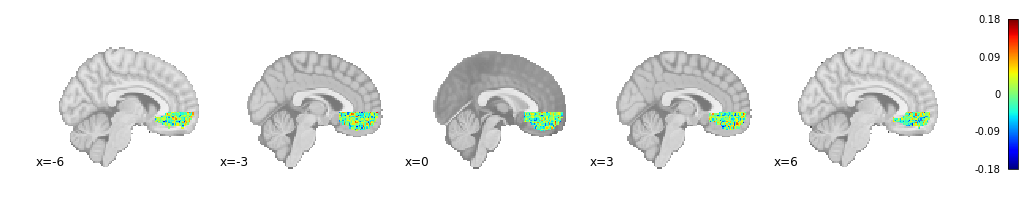

In [18]:
#plotting predict_real_corr data on brain

fig=nlp.plot_stat_map(predict_real_corr_niiname,display_mode='x',cut_coords=range(-6, 7, 3),cmap='jet')

figname=r"/home/donghui/Public/dh_test/predict_real_corr_vmpfc.svg"
fig.savefig(figname,dpi=600)